This notebook illustrates basic usage of the `ergochemics` package. Each section covers one module of the package:

1. `ergochemics.draw` | Convenient drawing functions for molecules and reactions.
2. `ergochemics.mapping` | For mapping reaction rules to reactions, generating atom-mapped reactions, and extracting reaction centers.
3. `ergochemics.standardize` | Customizable molecule and reaction standardization techniques.
4. `ergochemics.similarity` | Featurization and similarity for molecules and reactions.

In [ ]:
from ergochemics.draw import draw_molecule, draw_reaction
from ergochemics.mapping import operator_map_reaction, get_reaction_center
from ergochemics.standardize import (
    standardize_mol,
    standardize_smiles,
    standardize_reaction,
    hash_molecule,
    hash_reaction
)
from ergochemics.similarity import (
    MorganFingerprinter,
    ReactionFingerprinter,
    MolFeaturizer,
)
from IPython.display import SVG, display
from rdkit import Chem
import xml.dom.minidom as minidom
from collections import Counter
import numpy as np

# Draw

This module has all the neat functionality of RDKit wrapped up into convenient drawing functions. There is one function for drawing molecules and another for reactions. Both return SVGs (strings).

In [3]:
glutamic_acid_smi = 'C(CC(=O)[O-])[C@@H](C(=O)O)N'
svg = draw_molecule(glutamic_acid_smi)
pretty_print_svg = lambda svg: print(minidom.parseString(svg).toprettyxml(indent="  "))
pretty_print_svg(svg)

<?xml version="1.0" ?>
<svg xmlns="http://www.w3.org/2000/svg" xmlns:rdkit="http://www.rdkit.org/xml" xmlns:xlink="http://www.w3.org/1999/xlink" version="1.1" baseProfile="full" xml:space="preserve" width="200px" height="200px" viewBox="0 0 200 200">
  

  <!-- END OF HEADER -->
  

  <rect style="opacity:1.0;fill:#FFFFFF;stroke:none" width="200.0" height="200.0" x="0.0" y="0.0"> </rect>
  

  <path class="bond-0 atom-0 atom-1" d="M 95.0,92.0 L 68.6,109.2" style="fill:none;fill-rule:evenodd;stroke:#000000;stroke-width:2.0px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"/>
  

  <path class="bond-1 atom-1 atom-2" d="M 68.6,109.2 L 40.5,94.8" style="fill:none;fill-rule:evenodd;stroke:#000000;stroke-width:2.0px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"/>
  

  <path class="bond-2 atom-2 atom-3" d="M 43.0,96.1 L 42.3,82.5" style="fill:none;fill-rule:evenodd;stroke:#000000;stroke-width:2.0px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"/>
  

  <

In interactive Python notebooks like this one, you can hand SVGs to `IPYthon.display.SVG` to render them as images.

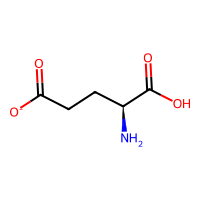

In [4]:
SVG(svg)

To display the image in the middle of a code block, use `IPython.display.display`

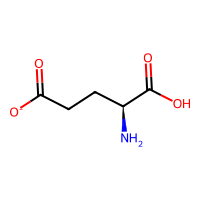

Hooray for display !


In [5]:
display(SVG(svg))
print("Hooray for display !")

By the way you can all pass `rdkit.Chem.Mol` objects as well as SMILES.

In [6]:
glutamic_acid_mol = Chem.MolFromSmiles(glutamic_acid_smi)
_svg = draw_molecule(glutamic_acid_mol)
assert svg == _svg

Here is a demonstration of some of the draw options. For a full list see the `draw_molecule` doc string or [RDKit Docs](https://www.rdkit.org/docs/source/rdkit.Chem.Draw.rdMolDraw2D.html#rdkit.Chem.Draw.rdMolDraw2D.MolDrawOptions).

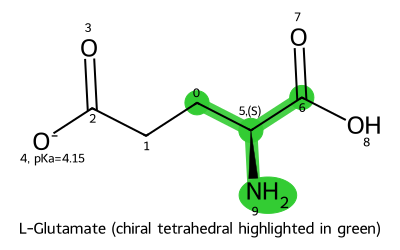

In [22]:
glutamic_acid_mol.GetAtomWithIdx(4).SetProp('atomNote', ' pKa=4.15')
display(
    SVG(
        draw_molecule(
            molecule=glutamic_acid_mol,
            size=(400, 250),
            highlight_atoms=(0, 5, 6, 9),
            draw_options={
                'addAtomIndices': True, # Example of a property set to `True`
                'addBondIndices': False, # Example of a property set to `False`
                'setHighlightColour': (0.2, 0.8, 0.2, 0.9), # Example of a callable that takes a tuple argument; pass a tuple
                'useBWAtomPalette': None, # Example of a callable that takes no arguments; pass `None`
                'addStereoAnnotation': True

            },
            legend="L-Glutamate (chiral tetrahedral highlighted in green)"
        )
    )
)

Here's an example of drawing a reaction.

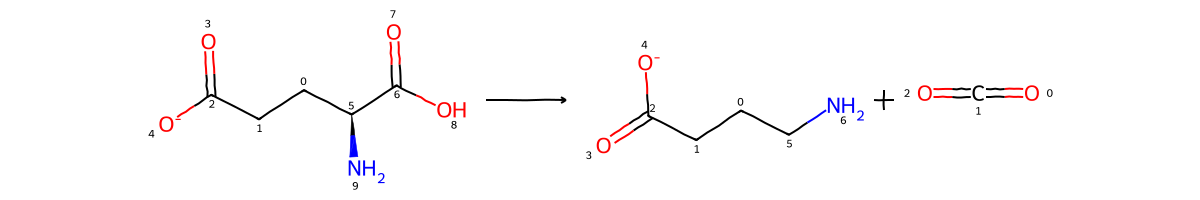

In [8]:
decarboxylation = 'C(CC(=O)[O-])[C@@H](C(=O)O)N>>C(CC(=O)[O-])CN.O=C=O'
display(
    SVG(
        draw_reaction(
            rxn=decarboxylation,
            sub_img_size=(300, 200),
            draw_options={
                'addAtomIndices': True,
                'comicMode': True,
            },
        )
    )
)

# Mapping

The purpose of this module is to support "mapping" a reaction rule to a reaction, in other words asking if the transformation specified in the reaction rule generates the product(s) of the reaction from its reactant(s). The main function here is `operator_map_reaction` (reaction rules are sometimes called operators). The below rule removes a carboxylic acid group if it is bound to a carbon which is in turn bound to an amino group. It should be enough to recapitulate the decarboxylation reaction above.

In [9]:
rule = "[O:1][C:2][C:3][N:4]>>[C:3][N:4].[O:1]=[C:2]"
res = operator_map_reaction(rxn=decarboxylation, operator=rule)

[12:00:17] Initializing MetalDisconnector
[12:00:17] Running MetalDisconnector
[12:00:17] Initializing Normalizer
[12:00:17] Running Normalizer
[12:00:17] Initializing MetalDisconnector
[12:00:17] Running MetalDisconnector
[12:00:17] Initializing Normalizer
[12:00:17] Running Normalizer
[12:00:17] Initializing MetalDisconnector
[12:00:17] Running MetalDisconnector
[12:00:17] Initializing Normalizer
[12:00:17] Running Normalizer


The output of `operator_map_reaction` also includes helpful information such as the atom-mapped reaction according to the rule and indices of atoms that matched the template, permuted to the order in which they appear in the rule.

In [10]:
print(f"Did the rule map the reaction?  {res.did_map}")
print(f"Atom mapped reaction: {res.atom_mapped_smarts}")
print(f"Indices of the atoms that matched the rule's template: {res.template_aidxs}")
am_rxn = res.atom_mapped_smarts

Did the rule map the reaction?  True
Atom mapped reaction: [NH2:2][CH:1]([CH2:3][CH2:4][C:5](=[O:6])[OH:7])[C:9](=[O:10])[OH:8]>>[NH2:2][CH2:1][CH2:3][CH2:4][C:5](=[O:6])[OH:7].[O:8]=[C:9]=[O:10]
Indices of the atoms that matched the rule's template: (((9, 7, 1, 0),), ((0, 1), (0, 1)))


Given an atom-mapped reaction such as the above, we can use the function `get_reaction_center` to return the indices of reaction center atoms, in other words the simplest reaction rule which would recapitulate the reaction. There is an option to separate those atom indices into a tuple per separate molecule, or to consider each side of the reaction as a kind of super molecule, a disjoint multi-molecular graph.

In [11]:
print(f"Separate: {get_reaction_center(res.atom_mapped_smarts, mode="separate")}")
print(f"Combined: {get_reaction_center(res.atom_mapped_smarts, mode="combined")}")

Separate: (((1, 7, 9),), ((1,), (0, 1)))
Combined: ((1, 7, 9), (1, 7, 8))


# Standardize

Cheminformatics must deal with a basic, thorny issue that there are often multiple valid representations of a single chemical object, usually a molecule. Degeneracy occurs in different ways. There are often multiple valid SMILES describing a single molecule, molecules can exist in different protonation states, tautomeric forms, etc. How exactly one chooses to clean up this situation will depend on their specific needs. The `standardize` module offers several options which allow for the easy implementation of a variety of approaches to standardization. The most important function here is `standardize_mol` which accepts and returns an `rdkit.Chem.Mol` object.

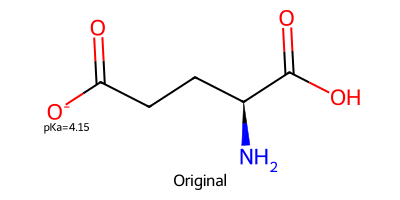

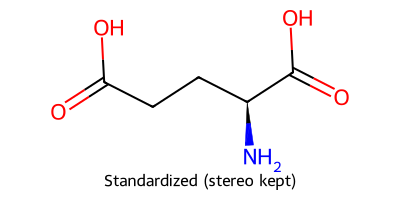

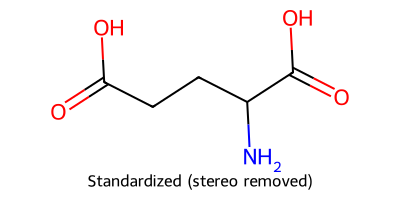

In [12]:
std_mol = standardize_mol(glutamic_acid_mol)
std_mol_w_stereo = standardize_mol(glutamic_acid_mol, do_remove_stereo=False)
size = (400, 200)
display(SVG(draw_molecule(glutamic_acid_mol, size=size, legend="Original")))
display(SVG(draw_molecule(std_mol_w_stereo, size=size, legend="Standardized (stereo kept)")))
display(SVG(draw_molecule(std_mol, size=size, legend="Standardized (stereo removed)")))

`standardize_smiles` accepts and returns SMILES.

In [13]:
std_smi = standardize_smiles(glutamic_acid_smi)
print(f"Original SMILES: {glutamic_acid_smi}")
print(f"Standardized SMILES: {std_smi}")

Original SMILES: C(CC(=O)[O-])[C@@H](C(=O)O)N
Standardized SMILES: NC(CCC(=O)O)C(=O)O


`standardize_reaction` is a convenience function that applies `standardize_smiles` to each molecule's SMILES contained in the input reaction.

In [14]:
std_rxn = standardize_reaction(decarboxylation)
print(f"Original reaction: {decarboxylation}")
print(f"Standardized reaction: {std_rxn}")

Original reaction: C(CC(=O)[O-])[C@@H](C(=O)O)N>>C(CC(=O)[O-])CN.O=C=O
Standardized reaction: NC(CCC(=O)O)C(=O)O>>NCCCC(=O)O.O=C=O


Given a standardized SMILES representation of a molecule or reaction, the `hash_molecule` and `hash_reaction` functions return a fixed length hash of their input. `hash_reaction` lexicographically sorts the molecule SMILES on each side of the reaction so as to be invariant to the particular order of reactants or products. It is however sensitive to reaction direction.

In [15]:
print(f"Hash of original molecule: {hash_molecule(std_smi)}")
print(f"Hash of standardized reaction: {hash_reaction(std_rxn)}")

Hash of original molecule: b77dad6d2dff6ce82f151c948bc324c70d7cff80
Hash of standardized reaction: f603af8a0f12cc056d8b7aa90236d7ee63e4a11a


# Similarity

Morgan fingerprints, aka ECFP, are a common way to get a vector representation of a molecules. In summary, they work by fragmenting the molecule and hashing the fragments. `MorganFingerprinter` is a convenience class for `RDKit`'s fingerprinting functionality.

In [16]:
mfper = MorganFingerprinter(
    radius=2,
    length=1024,
    mol_featurizer=MolFeaturizer()
)
std_mol = Chem.MolFromSmiles(std_smi)
mfp = mfper.fingerprint(std_mol)
ct_mfp = mfper.fingerprint(std_mol, output_type='count')
print(f"Binary MFP unique elements: {dict(Counter(mfp))}")
print(f"Count-based MFP unique elements: {dict(Counter(ct_mfp))}")

Binary MFP unique elements: {np.uint8(0): 1006, np.uint8(1): 18}
Count-based MFP unique elements: {np.uint32(0): 1006, np.uint32(2): 7, np.uint32(1): 11}


By changing the features used to describe the atoms, one can get different sorts of fingerprints tailored for different use cases. For instance, if all atoms were given the same constant feature, the resulting fingerprints would represent the molecule's topology only. We can achieve this by passing a custom atom featurizer function to `MolFeaturizer` which is in turn passed to `MorganFingerprinter`. Any function that accepts a `rdkit.Chem.Atom` and returns a `list[float | int]` is considered a valid atom featurizer.

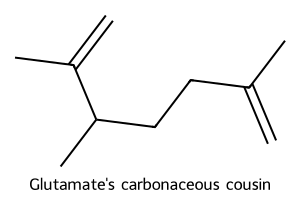

In [17]:
def constant_atom_featurizer(atom: Chem.Atom) -> list[float | int]:
    return [1.0]

gcc = Chem.MolFromSmiles('CC(=C)CCC(C)C(=C)C')

display(
    SVG(
        draw_molecule(
            gcc,
            size=(300, 200),
            legend="Glutamate's carbonaceous cousin"
        )
    )
)

topology_featurizer = MolFeaturizer(
    atom_featurizer=constant_atom_featurizer
)

topo_mfper = MorganFingerprinter(
    radius=2,
    length=1024,
    mol_featurizer=topology_featurizer
)

gcc_topo_mfp = topo_mfper.fingerprint(gcc)
glutamate_topo_mfp = topo_mfper.fingerprint(std_mol)

assert np.allclose(gcc_topo_mfp, glutamate_topo_mfp)

`ReactionFingerprinter` extends Morgan fingerprints to reactions and, optionally, provides minimum topological distance to the reaction center as an atom feature. This provides reaction fingerprints with some information on relative location of atoms which can be important for the feasibility of that reaction.

In [18]:
rxn_mfper = ReactionFingerprinter(
    radius=2,
    length=1024,
    mol_featurizer=MolFeaturizer()
)

rxnfp_w_rc_loc = rxn_mfper.fingerprint(am_rxn, use_rc=True)
rxnfp_wo_rc_loc = rxn_mfper.fingerprint(am_rxn, use_rc=False)

print(np.allclose(rxnfp_w_rc_loc, rxnfp_wo_rc_loc))

False


For more in depth information on reaction similarity, see `reaction_similarity.ipynb` located in the `examples` directory.